In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import math
import timeit
from downfun import *
from damoscrape import *

# Establishing Session

In [2]:
###Define Session, namely User-Agent
rs = requests.Session()
rs.headers['User-Agent'] = 'Mozilla/5.0 (MacBook Pro; Intel Mac OS X 11.15.7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.1 Safari/605.1.15'

# Yfinance Check

In [3]:
portfolio_tickers = ["BB", "BP", "AMD", "AAL", "PLTR", "KO", "V", "CRM"]
portfolio_weights = np.repeat(1/len(portfolio_tickers), len(portfolio_tickers))
portfolio = yf.Tickers(" ".join(portfolio_tickers))

In [4]:
[portfolio.tickers[i].info.get('sector') for i in portfolio_tickers]
[portfolio.tickers[i].info.get('marketCap') for i in portfolio_tickers]
[portfolio.tickers[i].info.get('industry') for i in portfolio_tickers]
[portfolio.tickers[i].info.get('previousClose') for i in portfolio_tickers]

[11.55, 25.58, 89.74, 20.35, 23.08, 54.13, 236.61, 245.8]

# Financial Statements

In [5]:
port_financial = {i : portfolio.tickers[i].get_financials() for i in portfolio_tickers}
port_balance_sheet = {i : portfolio.tickers[i].get_balance_sheet() for i in portfolio_tickers}
port_cashflow = {i : portfolio.tickers[i].get_cashflow() for i in portfolio_tickers}

In [6]:
port_financial['BB'].head(3)

,2021-02-28,2020-02-29,2019-02-28,2018-02-28
Research Development,2.15e+08,2.59e+08,2.17e+08,2.34e+08
Effect Of Accounting Charges,None,None,None,None
Income Before Tax,-1.113e+09,-1.48e+08,7.7e+07,4.06e+08


# Mean - Variance

In [7]:
port_stock_history = {ticker : portfolio.tickers[ticker].history(period = "5y") for ticker in portfolio_tickers} 

In [8]:
for ticker in port_stock_history:
    port_stock_history[ticker]['log_returns'] = np.log(port_stock_history[ticker].Close/port_stock_history[ticker].Close.shift(1))

In [9]:
#Daily
mean_log_rets = {ticker : port_stock_history[ticker].log_returns.mean() for ticker in portfolio_tickers}
stdev_log_rets = {ticker : port_stock_history[ticker].log_returns.std() for ticker in portfolio_tickers}
mean_log_rets

{'BB': 0.00045042752672533895,
 'BP': -5.6935198760519785e-06,
 'AMD': 0.0023039141949030314,
 'AAL': -0.0002862544127847607,
 'PLTR': 0.004622331570101256,
 'KO': 0.00027224694805209925,
 'V': 0.0009298551397935187,
 'CRM': 0.0008735602049456065}

In [10]:
#Monthly
monthly_log_returns = {ticker: port_stock_history[ticker].resample('M')['log_returns'].sum() for ticker in portfolio_tickers}
pd.concat(monthly_log_returns, axis = 1).apply(np.mean)
pd.concat(monthly_log_returns, axis = 1).apply(np.std)

BB      0.156899
BP      0.071595
AMD     0.155113
AAL     0.129693
PLTR    0.339217
KO      0.047376
V       0.055971
CRM     0.076386
dtype: float64

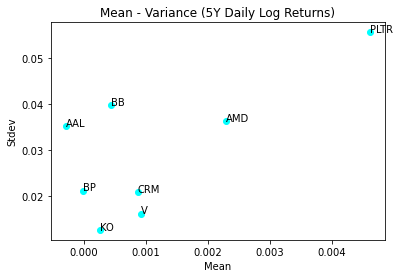

In [11]:
plt.scatter(x = mean_log_rets.values(), y = stdev_log_rets.values(), color = 'cyan')
plt.title("Mean - Variance (5Y Daily Log Returns)")
plt.xlabel("Mean")
plt.ylabel("Stdev")
for ticker in portfolio_tickers:
    plt.annotate(ticker, (mean_log_rets[ticker], stdev_log_rets[ticker]))

# Finratios, Balratios and Fin_analysis functions
- `finratios` returns basic financial statement ratios and some key data (total revenue, net income, growth rates, etc.)
- `balratios` returns summarised and augmented balance sheet for valuation purposes
- `fin_analysis` returns key valuation metrics (uses finratios and balratios internally)

In [12]:
tickers = ["BB", "BP", "AMD", "AAL", "KO", "V", "CRM"]
findict = {t : finratios(t, rs) for t in tickers}
baldict = {t : balratios(t, rs) for t in tickers}

In [13]:
findict["BB"]

,2021-02-28,2020-02-29,2019-02-28,2018-02-28
Total Revenue,8.930000e+08,1.040000e+09,9.040000e+08,9.320000e+08
Net Income,-1.104000e+09,-1.520000e+08,9.300000e+07,4.050000e+08
NOPLAT,-9.522372e+07,-2.095135e+08,-5.193506e+07,-1.057389e+08
gNS,-1.470000e+08,1.360000e+08,-2.800000e+07,NaN
gNI,-9.520000e+08,-2.450000e+08,-3.120000e+08,NaN
Gross Margin,2.799552e-01,2.615385e-01,2.256637e-01,2.693133e-01
Operating Margin,-1.075028e-01,-1.961538e-01,-4.756637e-02,-1.137339e-01
Net Margin,-1.236282e+00,-1.461538e-01,1.028761e-01,4.345494e-01
Net Financial Expense,1.017000e+09,-5.600000e+07,-1.200000e+08,-5.120000e+08
Interest Expense,-1.500000e+07,-2.300000e+07,-2.400000e+07,-2.300000e+07


In [14]:
baldict['BP']

,2020-12-31,2019-12-31,2018-12-31,2017-12-31
Total Assets,2.676540e+11,2.951940e+11,2.821760e+11,2.765150e+11
Total Liabilities,1.820860e+11,1.944860e+11,1.806280e+11,1.761110e+11
Total Equity,7.122900e+10,9.839100e+10,9.942300e+10,9.847000e+10
Current Operating Assets,7.264900e+10,8.189000e+10,7.108800e+10,7.484300e+10
Current Operating Liabilties,4.148100e+10,5.359400e+10,5.196600e+10,4.944100e+10
Working Capital,1.318300e+10,8.464000e+09,3.073000e+09,1.024200e+10
Operating Working Capital,3.116800e+10,2.829600e+10,1.912200e+10,2.540200e+10
LT Operating Assets,1.645890e+11,1.815340e+11,1.832050e+11,1.753170e+11
LT Operating Liabilities,5.898200e+10,6.365400e+10,5.658800e+10,5.620600e+10
NTA,1.056070e+11,1.178800e+11,1.266170e+11,1.191110e+11


In [15]:
fin_analysis('AMD',rs)

,2020-12-26,2019-12-28,2018-12-29,2017-12-30
PM,0.272778,0.085933,0.071564,0.053189
ROE,0.880792,0.269352,0.565436,NaN
ROIC,0.619045,0.182870,0.189365,NaN
netIR,0.060339,0.136531,0.066451,NaN
IR,-0.031864,-0.049552,-0.065370,NaN
FINLEV,0.241391,0.521755,1.498420,3.105705
SPR,0.650910,0.232422,0.254735,NaN
ICTO,2.269410,2.128043,2.646097,NaN
NTAT,9.599803,8.787206,8.726415,NaN
WCT,2.971994,2.808093,3.797654,NaN


# Scraping Damodaran's Website
- `DamoData`: parent class
    - Attributes
        - `base.url`: http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/
        - `industry_xls`: Address of the xls sheet containing information on the industry groupings (classification of companies into industries)
        - `hrefs`: href attributes of the hyperlinks to the individual datafiles
        - `htms`: created by getLinks() method
        - `ind_group`: created by lookupCompany() method 
    - Methods
        - `getSoup`: auxillary method to get BeautifulSoup objects
        - `getLinks`: get only links to the HTM files and saves them to .htms attribute
        - `getPngs`: get only .png links
        - `getXls`: get .xls links
        - `listNames`: list all clean names of the links (cleaned for \[dot\] and \[underscore\] extensions)
        - `lookupCompany`: first call created new attribute from the reading the excel file stored at `industry_xls` link (takes approx 30-40sec), subsequent calls can search the dataframe filtering by companies, tickers and countries
        
- `IndustryData`: inhertied class of `DamoData`, takes `var` as input (available var names stored in .htms attribute, created after getLinks is called internally)
    - Attributes
        - `var`: user inputted
        - `links`: calls getLinks() method of parent class
        - `url`: selects the correct link based on the user input
    - Methods
        - `getTable`: bottom-up approach of getting the html table into pandas dataframe (deals with reading the columns rows, columns names and indexing)
        - `rawTable`: returns raw table as a result of looping through html table's rows and columns
        - `parseTable`: returns clean dataframe using pd.read_html and cleans dataframe values of parentheses, double-spaces and tabs as well as turns values including '%' into decimals   

In [16]:
damo = DamoData()

In [17]:
damo.listNames()[:6]

['?C=N;O=D', '?C=M;O=A', '?C=S;O=A', '?C=D;O=A', '/~adamodar/New', 'Betas']

In [18]:
damo.getLinks()[:6]

['http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/COVIDeffects.htm',
 'http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/CountryERPlist.htm',
 'http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/DollarUS.htm',
 'http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/EVA.htm',
 'http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/EVAtemp.htm',
 'http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/EVAx.htm']

In [19]:
damo.getPngs()[:3]

['http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/DbtReg1.png',
 'http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/DbtReg2.png',
 'http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/Div1for2021.png']

In [20]:
damo.getXls()[:3]

['http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/capex.xls',
 'http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/dbtratio.xls',
 'http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/divratio.xls']

In [21]:
damo.lookupCompany(name = "Apple", ticker = "AAPL")

,Company Name,Exchange:Ticker,Industry Group,Country,Broad Group,Sub Group
2648,Apple Inc. (NasdaqGS:AAPL),NasdaqGS:AAPL,Computers/Peripherals,United States,United States,United States


In [22]:
#new attribute from lookupCompany method stored in .ind_group
damo.ind_group.head(5)

,Company Name,Exchange:Ticker,Industry Group,Country,Broad Group,Sub Group
0,"""Bank ""Saint-Petersburg"" Public Joint-Stock Co...",MISX:BSPB,Bank (Money Center),Russia,Emerging Markets,Eastern Europe & Russia
1,@Health SA (ENXTPA:MLAHC),ENXTPA:MLAHC,Healthcare Products,France,Developed Europe,EU & Environs
2,01 Communique Laboratory Inc. (TSXV:ONE),TSXV:ONE,Software (System & Application),Canada,"Australia, NZ and Canada",Canada
3,01Cyberaton Proenergy Spolka Akcyjna (WSE:01C),WSE:01C,Green & Renewable Energy,Poland,Developed Europe,EU & Environs
4,1 Production Film Co. (GTSM:8458),GTSM:8458,Entertainment,Taiwan,Emerging Markets,Small Asia


In [23]:
#after new attribute is created the search just goes thru the ind_group dataframe
damo.lookupCompany(name = "Facebook", ticker = "FB")

,Company Name,Exchange:Ticker,Industry Group,Country,Broad Group,Sub Group
13485,"Facebook, Inc. (NasdaqGS:FB)",NasdaqGS:FB,Software (Entertainment),United States,United States,United States


In [24]:
#Children class of DamoData(), takes the var argument specifying the variable of interest, all relevant variables can be found via .listNames()
#IndustryData ONLY parses through .htm links --> available variables stored in .htms attribute
ind_data = IndustryData('wacc')
industry_wacc = ind_data.parseTable()

In [25]:
ind_data.htms[:4]

['COVIDeffects.htm', 'CountryERPlist.htm', 'DollarUS.htm', 'EVA.htm']

In [26]:
industry_wacc.index #industries

Index(['Advertising', 'Aerospace/Defense', 'Air Transport', 'Apparel',
       'Auto & Truck', 'Auto Parts', 'Bank Money Center', 'Banks Regional',
       'Beverage Alcoholic', 'Beverage Soft', 'Broadcasting',
       'Brokerage & Investment Banking', 'Building Materials',
       'Business & Consumer Services', 'Cable TV', 'Chemical Basic',
       'Chemical Diversified', 'Chemical Specialty', 'Coal & Related Energy',
       'Computer Services', 'Computers/Peripherals', 'Construction Supplies',
       'Diversified', 'Drugs Biotechnology', 'Drugs Pharmaceutical',
       'Education', 'Electrical Equipment', 'Electronics Consumer & Office',
       'Electronics General', 'Engineering/Construction', 'Entertainment',
       'Environmental & Waste Services', 'Farming/Agriculture',
       'Financial Svcs. Non-bank & Insurance', 'Food Processing',
       'Food Wholesalers', 'Furn/Home Furnishings', 'Green & Renewable Energy',
       'Healthcare Products', 'Healthcare Support Services',
       'Hea

In [27]:
industry_wacc #sum table 

,Number of Firms,Beta,Cost of Equity,E/(D+E),Std Dev in Stock,Cost of Debt,Tax Rate,After-tax Cost of Debt,D/(D+E),Cost of Capital
Industry Name,,,,,,,,,,
Advertising,61,1.08,0.0601,0.5634,0.5774,0.0300,0.0335,0.0219,0.4366,0.0434
Aerospace/Defense,72,1.07,0.0596,0.7516,0.3489,0.0258,0.0737,0.0188,0.2484,0.0495
Air Transport,17,1.61,0.0852,0.3826,0.4615,0.0300,0.0600,0.0219,0.6174,0.0461
Apparel,51,1.10,0.0611,0.7174,0.4784,0.0300,0.0475,0.0219,0.2826,0.0500
Auto & Truck,19,1.28,0.0698,0.7212,0.4524,0.0300,0.0786,0.0219,0.2788,0.0565
...,...,...,...,...,...,...,...,...,...,...
Trucking,35,1.11,0.0618,0.7476,0.3878,0.0258,0.0970,0.0188,0.2524,0.0509
Utility General,16,0.74,0.0442,0.5724,0.1844,0.0192,0.0974,0.0140,0.4276,0.0313
Utility Water,17,0.73,0.0439,0.7119,0.3596,0.0258,0.1079,0.0188,0.2881,0.0367


In [28]:
industry_wacc.loc['Semiconductor']

Number of Firms           70.0000
Beta                       1.0000
Cost of Equity             0.0566
E/(D+E)                    0.9115
Std Dev in Stock           0.3726
Cost of Debt               0.0258
Tax Rate                   0.0641
After-tax Cost of Debt     0.0188
D/(D+E)                    0.0885
Cost of Capital            0.0533
Name: Semiconductor, dtype: float64

In [29]:
#alternative methods to get the dataframe
# getTable uses bottom.up approach to get the table instead of pd.read_html()
# rawTable gets rawTable by only looping through rows and columns of the html table --> need to set columns, indices and clean table
ind_data.getTable()

,Number of Firms,Beta,Cost of Equity,E/(D+E),Std Dev in Stock,Cost of Debt,Tax Rate,After-tax Cost of Debt,D/(D+E),Cost of Capital
Industry Name,,,,,,,,,,
Advertising,61,1.08,6.01%,56.34%,57.74%,3.00%,3.35%,2.19%,43.66%,4.34%
Aerospace/Defense,72,1.07,5.96%,75.16%,34.89%,2.58%,7.37%,1.88%,24.84%,4.95%
Air Transport,17,1.61,8.52%,38.26%,46.15%,3.00%,6.00%,2.19%,61.74%,4.61%
Apparel,51,1.10,6.11%,71.74%,47.84%,3.00%,4.75%,2.19%,28.26%,5.00%
Auto & Truck,19,1.28,6.98%,72.12%,45.24%,3.00%,7.86%,2.19%,27.88%,5.65%
...,...,...,...,...,...,...,...,...,...,...
Utility (General),16,0.74,4.42%,57.24%,18.44%,1.92%,9.74%,1.40%,42.76%,3.13%
Utility (Water),17,0.73,4.39%,71.19%,35.96%,2.58%,10.79%,1.88%,28.81%,3.67%
Total Market,7582,0.94,5.37%,67.42%,41.21%,3.00%,5.76%,2.19%,32.58%,4.34%


In [30]:
ind_data.rawTable()

,0,1,2,3,4,5,6,7,8,9,10
0,Industry\r\n Name,Number of Firms,Beta,Cost of Equity,E/(D+E),Std Dev in Stock,Cost of Debt,Tax Rate,After-tax Cost of Debt,D/(D+E),Cost of Capital
1,Advertising,61,1.08,6.01%,56.34%,57.74%,3.00%,3.35%,2.19%,43.66%,4.34%
2,Aerospace/Defense,72,1.07,5.96%,75.16%,34.89%,2.58%,7.37%,1.88%,24.84%,4.95%
3,Air\r\n Transport,17,1.61,8.52%,38.26%,46.15%,3.00%,6.00%,2.19%,61.74%,4.61%
4,Apparel,51,1.10,6.11%,71.74%,47.84%,3.00%,4.75%,2.19%,28.26%,5.00%
...,...,...,...,...,...,...,...,...,...,...,...
93,Utility\r\n (General),16,0.74,4.42%,57.24%,18.44%,1.92%,9.74%,1.40%,42.76%,3.13%
94,Utility (Water),17,0.73,4.39%,71.19%,35.96%,2.58%,10.79%,1.88%,28.81%,3.67%
95,Total\r\n Market,7582,0.94,5.37%,67.42%,41.21%,3.00%,5.76%,2.19%,32.58%,4.34%
96,Total Market (without financials),6253,0.98,5.55%,79.93%,44.77%,3.00%,4.39%,2.19%,20.07%,4.87%
